In [21]:
import warnings # to deal with warnings
warnings.filterwarnings("ignore")  # supress all warnings 

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import re
import random

from math import sqrt

from scipy.linalg import cho_factor, cho_solve
from scipy.stats import boxcox, shapiro, norm, levene

from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV # for LASSO
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt # for hist()
import plotly.express as px
from plotnine import *

# Read in Data

In [6]:
data = pd.read_csv("./data/SpotifyData.csv")
df = pd.DataFrame(data)
df = df.iloc[:-3,] # last 3 rows are all NAs so remove them
df.head(5)

,title,artist,top genre,year released,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type
0,STARSTRUKK (feat. Katy Perry),3OH!3,dance pop,2009.0,2022‑02‑17,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo
1,My First Kiss (feat. Ke$ha),3OH!3,dance pop,2010.0,2022‑02‑17,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo
2,I Need A Dollar,Aloe Blacc,pop soul,2010.0,2022‑02‑17,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo
3,Airplanes (feat. Hayley Williams of Paramore),B.o.B,atl hip hop,2010.0,2022‑02‑17,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo
4,Nothin' on You (feat. Bruno Mars),B.o.B,atl hip hop,2010.0,2022‑02‑17,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo


Since the `top genre` has a large number of categories and a lot of "niche" genres with only a few entries, we recode the variable so that the categories are broader.

In [7]:
df["top genre"] = df["top genre"].astype(str)
mapping = ['dance pop', 'pop', 'hip hop', 'rap', 'rock', 'r&b', 'house', 'dance', 'indie', 'edm', 'country', 'boy band']
df['top genre broad'] = df['top genre'].apply(lambda x: [k for k in mapping if re.search(k, x)])
df['top genre broad'] = df['top genre broad'].str[0]
df["top genre broad"].fillna('other', inplace=True)
df = df.drop(["top genre"], axis=1)
df.head(5)

,title,artist,year released,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type,top genre broad
0,STARSTRUKK (feat. Katy Perry),3OH!3,2009.0,2022‑02‑17,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo,dance pop
1,My First Kiss (feat. Ke$ha),3OH!3,2010.0,2022‑02‑17,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo,dance pop
2,I Need A Dollar,Aloe Blacc,2010.0,2022‑02‑17,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo,pop
3,Airplanes (feat. Hayley Williams of Paramore),B.o.B,2010.0,2022‑02‑17,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo,hip hop
4,Nothin' on You (feat. Bruno Mars),B.o.B,2010.0,2022‑02‑17,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo,hip hop


In [8]:
A = df.iloc[:, [4,5,6,7,8,9,10,11,12,13,14,15,16]] # want `bpm` to `top genre broad` cols
A.insert(0, "intercept", 1, True) # insert row of 1s for intercept
A.head()

,intercept,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type,top genre broad
0,1,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo,dance pop
1,1,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo,dance pop
2,1,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo,pop
3,1,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo,hip hop
4,1,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo,hip hop


Label encode the categorical variables:

In [9]:
label_encoder = preprocessing.LabelEncoder()
A["top year"] = label_encoder.fit_transform(A["top year"])
A["artist type"] = label_encoder.fit_transform(A["artist type"])
A["top genre broad"] = label_encoder.fit_transform(A["top genre broad"])

# Checking Assumptions for Linear Model 

## Normality Assumption

In [10]:
# to avoid errors when creating ols model
df = df.rename(columns={"top year": "top_year", "top genre broad": "top_genre_broad", "artist type": "artist_type"})
df.head()

,title,artist,year released,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top_year,artist_type,top_genre_broad
0,STARSTRUKK (feat. Katy Perry),3OH!3,2009.0,2022‑02‑17,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo,dance pop
1,My First Kiss (feat. Ke$ha),3OH!3,2010.0,2022‑02‑17,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo,dance pop
2,I Need A Dollar,Aloe Blacc,2010.0,2022‑02‑17,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo,pop
3,Airplanes (feat. Hayley Williams of Paramore),B.o.B,2010.0,2022‑02‑17,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo,hip hop
4,Nothin' on You (feat. Bruno Mars),B.o.B,2010.0,2022‑02‑17,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo,hip hop


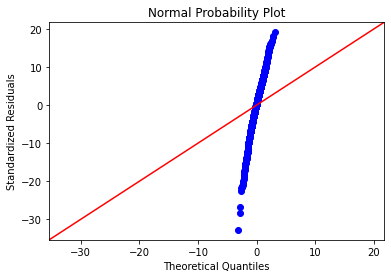

In [11]:
# building the model with the interaction terms
model = ols("pop ~ bpm + nrgy + dnce + dB + live + val + dur + acous + spch + C(top_year) + C(artist_type) + C(top_genre_broad) + C(top_year):C(top_genre_broad) + C(top_year):C(artist_type) + C(top_genre_broad):C(artist_type)", data=df).fit()

# creating the normal probability plot
sm.qqplot(model.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

The points don't follow the line at all, with large quantiles (positive and negative) indicating heavy tails in the data's distribution. The data violates the normality assumption.

Due to the response variable violating the normality assumption, a transformation is carried out:

In [12]:
pt = preprocessing.PowerTransformer(method="yeo-johnson")
pop_df = pd.DataFrame(A["pop"])
pt.fit(pop_df)
print(pt.lambdas_)  # optimal lambda value

[3.27087407]


In [13]:
transformed_data = pt.transform(pop_df)
df["pop"] = transformed_data
A["pop"] = transformed_data

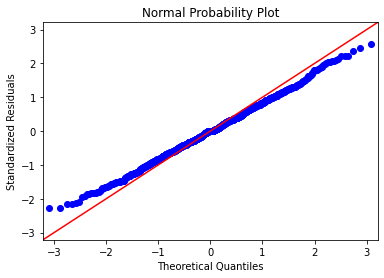

In [14]:
# re-building the model with the interaction term
model2 = ols("pop ~ bpm + nrgy + dnce + dB + live + val + dur + acous + spch + C(top_year) + C(artist_type) + C(top_genre_broad) + C(top_year):C(top_genre_broad) + C(top_year):C(artist_type) + C(top_genre_broad):C(artist_type)", data=df).fit()

# re-creating the normal probability plot
sm.qqplot(model2.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title("Normal Probability Plot")
plt.show()

In [15]:
A = A[[col for col in A if col not in ["pop"]] + ["pop"]] # move 'pop' column to last column
A.head(5)

,intercept,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,top year,artist type,top genre broad,pop
0,1,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,0,1,3,-0.688503
1,1,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,0,1,3,-0.893216
2,1,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,0,2,9,-0.470267
3,1,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,0,2,5,0.547680
4,1,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,0,2,5,0.407101


### Shapiro-Wilk's Test

We will also perform a Shapiro-Wilk's test to quantify the ability to accept/reject the normality assumption.

In [16]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
w, pvalue = shapiro(model2.resid)
print(w, pvalue)

0.9982758164405823 0.417789489030838


Since the p-value of about 0.4178 is greater than $\alpha$  = 0.05, we fail to reject the null hypothesis. There is stiatistically significant evidence to suggest that the normality assumption holds.

Lastly, we will use a histogram to visualize that the residuals are approximately normally distributed.

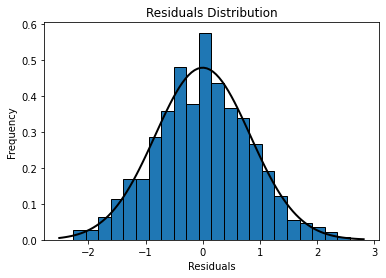

In [17]:
# Reference: https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data

# plot the residuals as a histogram
plt.hist(model2.resid, bins="auto", density=True, histtype="bar", ec="k")
mu, std = norm.fit(model2.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=2)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

   ## Homoscedasticity Assumption

To visualize our data's compliance to the homoscedasticity assumption, we will evaluate the residuals vs. fitted plot, as well as the Scale-Location plot. This plot displays the model's fitted values vs. square root of the standardized residuals.

TypeError: can't multiply sequence by non-int of type 'float'

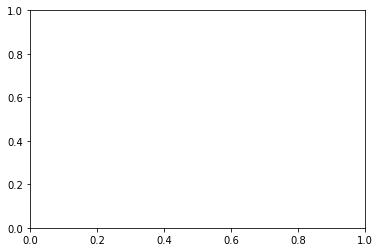

In [18]:
# Reference: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

# fitted values
model_fitted_y = model2.fittedvalues
# residuals
model_residuals = model2.resid
# normalized residuals
model_norm_residuals = model2.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model2.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model2.get_influence().cooks_distance[0]

# plot details and formatting
plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(
    model_fitted_y,
    df.columns[16],
    data=df,
    lowess=True,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red", "lw": 1, "alpha": 0.8},
)

plot_lm_1.axes[0].set_title("Residuals vs Fitted")
plot_lm_1.axes[0].set_xlabel("Fitted values")
plot_lm_1.axes[0].set_ylabel("Residuals")

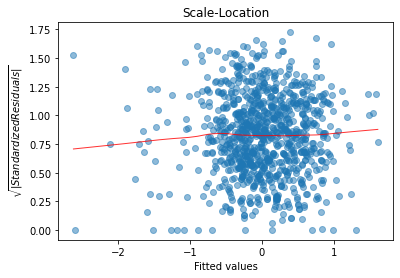

In [19]:
# Reference: https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

# plot details and formatting
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(
    model_fitted_y,
    model_norm_residuals_abs_sqrt,
    scatter=False,
    ci=False,
    lowess=True,
    line_kws={"color": "red", "lw": 1, "alpha": 0.8},
)
plot_lm_3.axes[0].set_title("Scale-Location")
plot_lm_3.axes[0].set_xlabel("Fitted values")
plot_lm_3.axes[0].set_ylabel("$\sqrt{|Standardized Residuals|}$")

# absolute normalized residuals
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)

# top 3 normalized residuals
abs_norm_resid_top_3 = abs_norm_resid[:3]

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(
        i, xy=(model_fitted_y[i], model_norm_residuals_abs_sqrt[i])
    )

### Levene's Test

We will also perform Levene's test check if the ten top years have equal variances in song popularity scores.

In [23]:
# for some reason, this didn't translate to the cleaned df so manually converting now
df['top_year'] = df['top_year'].astype(str)
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
stat, p = levene(
    df[df["top_year"] == "2010.0"]["pop"],
    df[df["top_year"] == "2011.0"]["pop"],
    df[df["top_year"] == "2012.0"]["pop"],
    df[df["top_year"] == "2013.0"]["pop"],
    df[df["top_year"] == "2014.0"]["pop"],
    df[df["top_year"] == "2015.0"]["pop"],
    df[df["top_year"] == "2016.0"]["pop"],
    df[df["top_year"] == "2017.0"]["pop"],
    df[df["top_year"] == "2018.0"]["pop"],
    df[df["top_year"] == "2019.0"]["pop"], 
)
print(stat, p)

1.6522907826763007 0.09622805208973864


Since the p-value of 0.0962 is greater than  $\alpha$ = 0.05, we fail to reject the null hypothesis. There is stiatistically significant evidence to suggest that the top years have equal variance.

We will also perform Levene's test check if the thirteen top genres have equal variances in song popularity scores.

In [24]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
stat, p = levene(
    df[df["top_genre_broad"] == "dance pop"]["pop"],
    df[df["top_genre_broad"] == "pop"]["pop"],
    df[df["top_genre_broad"] == "hip hop"]["pop"],
    df[df["top_genre_broad"] == "other"]["pop"],
    df[df["top_genre_broad"] == "rap"]["pop"],
    df[df["top_genre_broad"] == "rock"]["pop"],
    df[df["top_genre_broad"] == "boy band"]["pop"],
    df[df["top_genre_broad"] == "edm"]["pop"],
    df[df["top_genre_broad"] == "r&b"]["pop"],
    df[df["top_genre_broad"] == "dance"]["pop"],
    df[df["top_genre_broad"] == "country"]["pop"],
    df[df["top_genre_broad"] == "indie"]["pop"],
    df[df["top_genre_broad"] == "house"]["pop"],
)
print(stat, p)

1.7764492647996268 0.04756946781428622


Since the p-value of 0.0476 is less than $\alpha$ = 0.05, we reject the null hypothesis. There is stiatistically significant evidence to suggest that the top genres do not have equal variance.

We will also perform Levene's test check if the four artist types have equal variances in song popularity scores.

In [25]:
# reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html
stat, p = levene(
    df[df["artist_type"] == "Solo"]["pop"],
    df[df["artist_type"] == "Duo"]["pop"],
    df[df["artist_type"] == "Trio"]["pop"],
    df[df["artist_type"] == "Band/Group"]["pop"],
)
print(stat, p)

1.526734955044079 0.20595743890568496


Since the p-value of 0.2060 is greater than $\alpha$ = 0.05, we fail to reject the null hypothesis. There is stiatistically significant evidence to suggest that the artist types have equal variance.

After checking the normality and homoscedasticity assumptions, we will proceed with linear regression. We will also assume independence between observations

# Finding Regression Coefficients and their Standard Errors

### LU Decomposition

In [ ]:
X = np.array(A.drop(columns=["pop"])) # all columns but pop
y = np.array(A["pop"]) # pop is response var

XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)

B_lu = np.linalg.solve(XtX, Xty)
B_lu

In [ ]:
np.linalg.eigvals(XtX)

For the standard errors, we will first find an estimate of the variance using the formula $\hat{\sigma}^2 = (Y - X\hat{\beta})'(Y - X\hat{\beta})/(n-p)$:

In [ ]:
S = y - X.dot(B_lu)
n = X.shape[0] # number of rows of X
p = X.shape[1] # number of rows of X

sigma2_hat = np.matrix.transpose(S).dot(S) / (n-p)
sigma2_hat

Next we implement the formula $SE[\hat{\beta}] = \sqrt{\sigma^2 diag((X^TX)^{-1})}$ using `np.linalg.solve()` to find the inverse of $X^TX$:

In [ ]:
a = sigma2_hat * np.diag(np.linalg.inv(XtX))
np.sqrt(a)

### Cholesky Decomposition

In [ ]:
# using cho_factor() to obtain the lower-triangular Cholesky decomposition for X'X; equates to LL'
L, Lt = cho_factor(XtX, lower = True)

B_chol = cho_solve((L, Lt), Xty)
B_chol

We will then find the estimate of the variance for the standard errors. 

In [ ]:
aug_mat = np.array(A)
AtA = np.matrix.transpose(aug_mat).dot(aug_mat) # to ensure square matrix

L, Lt = cho_factor(AtA, lower = True)

d = L[L.shape[0]-1, L.shape[1]-1] # d is bottom right element of the lower triangular matrix

n = X.shape[0] # number of rows of X
p = X.shape[1] # number of cols of X

sigma2_hat = d**2/(n - p)
sigma2_hat

In [ ]:
L = np.linalg.cholesky(XtX)
a = sigma2_hat * np.diag(scipy.linalg.inv(L @ L.transpose()))
np.sqrt(a)

# LASSO Regression

In [ ]:
X = pd.DataFrame(X) # make numpy array into pandas df
X.columns = ["intercept", "bpm", "nrgy", "dnce", "dB", "live", "val", 
             "dur", "acous", "spch", "top year", "artist type", "top genre broad"]
X = X.drop(columns=["intercept"])

# splitting the data 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

# standardizing only the numerical columns
list_numerical = X.columns[:9]
scaler = preprocessing.StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [ ]:
# Reference: https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/

# creating a list of the LASSO coefficients from fitting the model to our dataset
coef = []

# defining alpha values; constant that multiplies the L1 term, controlling regularization strength
alphas = np.arange(0.01, 5, 0.10)

# defining the LASSO model
lasso = Lasso()

# for every alpha, re-fit the model and store the coefficients
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coef.append(lasso.coef_)

# plot the results: alpha values and coefficient values
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(alphas, coef)
ax.set_xlabel("Alpha (Regularization Parameter)")
ax.set_ylabel("LASSO Coefficients")
ax.set_title("Alpha vs. LASSO Coefficients")

We observe that initially, the model contains high magnitudes of predictor coefficients. As $\alpha$ (regularization parameter) values increase, the coefficient estimates converge to approximately zero.

### K Fold Cross Validation

In [ ]:
model = LassoCV(cv=10, random_state=1)
model.fit(X_train, y_train)

# best value of alpha after cross validation
optimal = model.alpha_
display(optimal)

In [ ]:
# building the LASSO model with the optimal lambda value
lasso_best = Lasso(alpha=optimal)
lasso_best.fit(X_train, y_train)

In [ ]:
print('R squared training set:', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set:', round(lasso_best.score(X_test, y_test)*100, 2))
print('MSE:', mean_squared_error(y_test, lasso_best.predict(X_test)))

In [ ]:
# organizing the predictors and their LASSO coefficients in a table
coefs = np.array(lasso_best.coef_)
comp = pd.DataFrame((X_test.columns, coefs)).T
comp = comp.rename({0: "Predictor", 1: "Coef"}, axis=1)
display(comp)

In [ ]:
# graph of residuals vs. fitted values
new_pred = lasso_best.predict(X_test)
new_resid = y_test - new_pred
display(px.scatter(x=new_pred, y=new_resid, labels={"x": "Predicted", "y": "Residuals"}))

The data points are randomly and evenly scattered about the horizontal line y = 0, so the linearity assumption holds pretty well. Also, the residuals roughly form a horizontal band around the line, indicating that the equal variance assumption holds as well.

In [ ]:
# removing the predictor coefficients that are zero
comp_selected = comp[comp['Coef'] != 0]
selected_features = comp_selected.Predictor.unique()

In [ ]:
y = pd.DataFrame(y) # numpy array to pandas df
y.columns = ["pop"]
LASSO_df = pd.concat([X[selected_features], y], axis=1)
LASSO_df.head()

So the variables selected are: nrgy, live, val, dur, acous, spch, top year, artist type, top genre.

In [ ]:
X = np.array(LASSO_df.drop(columns=["pop"])) # all columns but pop
y = np.array(LASSO_df["pop"]) # pop is response var

XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)

In [ ]:
B_lu = np.linalg.solve(XtX, Xty)
B_lu

In [ ]:
S = y - X.dot(B_lu)
n = X.shape[0] # number of rows of X
p = X.shape[1] # number of rows of X

sigma2_hat = np.matrix.transpose(S).dot(S) / (n-p)
sigma2_hat

In [ ]:
a = sigma2_hat * np.diag(np.linalg.inv(XtX))
np.sqrt(a)

In [ ]:
# using cho_factor() to obtain the lower-triangular Cholesky decomposition for X'X; equates to LL'
L, Lt = cho_factor(XtX, lower = True)

B_chol = cho_solve((L, Lt), Xty)
B_chol

In [ ]:
aug_mat = np.array(A)
AtA = np.matrix.transpose(aug_mat).dot(aug_mat) # to ensure square matrix

L, Lt = cho_factor(AtA, lower = True)

d = L[L.shape[0]-1, L.shape[1]-1] # d is bottom right element of the lower triangular matrix

n = X.shape[0] # number of rows of X
p = X.shape[1] # number of cols of X

sigma2_hat = d**2/(n - p)
sigma2_hat

In [ ]:
L = np.linalg.cholesky(XtX)
a = sigma2_hat * np.diag(scipy.linalg.inv(L @ L.transpose()))
np.sqrt(a)

# Simulation Study

In [ ]:
#num of observations
#n = 1000
# num of features
#p = 9
# determine the design matrix
#random.seed(108)

#X = np.array(np.random.normal(0, 1, n*p))
#X = X.reshape(n,p)

#beta = B_lu # beta coefficients from above
#sigma = 10

#y = X.dot(beta) + np.random.normal(0, sigma, n)

In [ ]:
random.seed(108)

n = 1000
p = 13

cols = A.columns.drop("pop")
X = np.array(
    [np.random.choice(A[x], 1000) for x in cols]
).T

X
X = X.reshape(n,p)
beta = B_lu # beta coefficients from above
sigma = 10

y = X.dot(beta) + np.random.normal(0, sigma, n)

In [ ]:
XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)

beta_est = np.linalg.solve(XtX, Xty)

S = y - X.dot(beta_est)
n = X.shape[0] # number of rows of X
p = X.shape[1] # number of rows of X

var = np.matrix.transpose(S).dot(S) / (n-p)
sigma_est = np.sqrt(var)

In [ ]:
pd.DataFrame(data={"True Beta": beta, "Beta Est": beta_est})

In [ ]:
print("True Sigma: " + str(sigma) + "\nEst sigma: "+str(sigma_est))

In [ ]:
#num_datasets = 100
#y_bar = X.dot(beta)
#Y = [y_bar+np.random.normal(0, sigma, n) for i in range(num_datasets)]
#Y = np.concatenate(Y, axis=0 )
#Y = Y.reshape(n, 100)

In [ ]:
num_datasets = 100

#cols = A.columns.drop("pop")
#print(cols)
#X_old = np.array([np.random.choice(A[x], 1000) for x in cols]).T

X = np.array([np.random.choice(A["bpm"], 1000)])
fin_mat = X

for i in range(num_datasets):
    cols = A.columns.drop(["bpm", "pop"])
    X = np.array([np.random.choice(A[x], 1000) for x in cols])
    fin_mat = np.vstack([fin_mat, X])
X = fin_mat.T
print(X.shape)

y = np.array([np.random.choice(A["pop"], 1000)]).T

In [ ]:
XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)
Beta =  np.linalg.solve(XtX, Xty)


n = X.shape[0] # number of rows of X
p = X.shape[1] # number of cols of X
S = (y - X @ Beta)**2
Sigma = np.sqrt(S.sum(axis = 0)/(n-p))
Sigma

In [ ]:
beta_df = pd.DataFrame(Beta)
beta_df.head(20)
# source: https://stackoverflow.com/questions/50529022/pandas-melt-unmelt-preserve-index

In [ ]:
beta_df2 = pd.melt(beta_df.reset_index(), id_vars="index").drop("variable", axis = 1)
beta_df2.head(20)

In [ ]:
(
ggplot(beta_df2) 
    + geom_histogram(aes(x="value"), bins = 10) 
    + facet_wrap("index", scales = "free_x")
    + geom_vline(xintercept = B_lu.mean(), colour = "blue")
    + geom_vline(xintercept = beta_df2.value.mean(), color = "red")
)

In [ ]:
(
ggplot() 
    + geom_histogram(aes(Sigma), bins = 15) 
    + geom_vline(xintercept = 10, color = 'blue')
    + geom_vline(xintercept = Sigma.mean(), color = 'red')
)